In [4]:
import requests
import pandas as pd
import os
from dotenv import load_dotenv

### 環境設定

In [11]:
# .env ファイルの読み込み
load_dotenv()

# 環境変数の取得
API_KEY = os.getenv("ETHERSCAN_API_KEY")
TOKEN_CONTRACT = "0xdAC17F958D2ee523a2206206994597C13D831ec7"  # USDTのコントラクトアドレス

### Ethreumのトークン取引履歴（USDTの最新100件）を取得

In [21]:
# 取得する取引件数
transactions = 1000

# APIリクエストURL
url = f"https://api.etherscan.io/api?module=account&action=tokentx&contractaddress={TOKEN_CONTRACT}&page=1&offset={transactions}&sort=desc&apikey={API_KEY}"

# データ取得
response = requests.get(url)
data = response.json()

# データをDataFrameに変換
df = pd.DataFrame(data['result'])

# 必要なカラムを選択
df = df[['timeStamp', 'from', 'to', 'value', 'tokenSymbol']]

# タイムスタンプを日時変換
df['timeStamp'] = pd.to_datetime(df['timeStamp'], unit='s')

# トークンの値を整数変換（USDTは小数点6桁分シフト）
df['value'] = df['value'].astype(float) / 10**6

# データ表示
df

C:\Users\fuben\AppData\Local\Temp\ipykernel_30468\154228592.py:18: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timeStamp'] = pd.to_datetime(df['timeStamp'], unit='s')


,timeStamp,from,to,value,tokenSymbol
0,2025-02-19 12:43:44,0x0ada3111b866ff1ad0477f0c5d2e8ed35a36eb5b,0xdae10aaaa4193f38db99ca6eb235ac79e94525ce,50.031455,USDT
1,2025-02-19 12:43:44,0x22863c875e6b7519141cb8394f2220fac7e6ade6,0xd315a9c38ec871068fec378e4ce78af528c76293,90.514241,USDT
2,2025-02-19 12:43:44,0x7b9b5876ecaef604ab0ff964f6ccc801198b2597,0x22863c875e6b7519141cb8394f2220fac7e6ade6,90.514241,USDT
3,2025-02-19 12:43:44,0x66a9893cc07d91d95644aedd05d03f95e1dba8af,0x46139c6b5cf640031647e2cc6e3df808c8f60d0d,50000.000000,USDT
4,2025-02-19 12:43:44,0x66a9893cc07d91d95644aedd05d03f95e1dba8af,0x000000fee13a103a10d593b9ae06b3e05f2e7e1c,125.000000,USDT
...,...,...,...,...,...
995,2025-02-19 12:39:28,0x3416cf6c708da44db2624d63ea0aaef7113527c6,0x663dc15d3c1ac63ff12e45ab68fea3f0a883c251,6135.335610,USDT
996,2025-02-19 12:39:28,0xc611ec3dbf324ac68f658e9f2e567811750f6d07,0xdabafcdd34273ab041aeebb0306dfdb7d3be0e55,5.000000,USDT
997,2025-02-19 12:39:28,0x66a9893cc07d91d95644aedd05d03f95e1dba8af,0x7b9b5876ecaef604ab0ff964f6ccc801198b2597,90.514241,USDT
998,2025-02-19 12:39:28,0x66a9893cc07d91d95644aedd05d03f95e1dba8af,0x000000fee13a103a10d593b9ae06b3e05f2e7e1c,0.226852,USDT


### 取引量の多いアドレスをリストアップ

In [22]:
# アドレスごとの取引量（送信量＋受信量）
top_senders = df.groupby('from')['value'].sum().reset_index().rename(columns={'from': 'address', 'value': 'sent_value'})
top_receivers = df.groupby('to')['value'].sum().reset_index().rename(columns={'to': 'address', 'value': 'received_value'})

# 送信と受信のデータをマージ
top_addresses = pd.merge(top_senders, top_receivers, on="address", how="outer").fillna(0)

# 合計取引量を算出
top_addresses["total_value"] = top_addresses["sent_value"] + top_addresses["received_value"]

# 取引量の多い順に並び替え
top_addresses = top_addresses.sort_values(by="total_value", ascending=False)

# 上位10アドレス表示
print(top_addresses.head(10))

                                         address    sent_value  \
3     0x0069d78b885f690964467c1b7ce5ad85ed076854  8.000000e+06   
103   0x28c6c06298d514db089934071355e5743bf21d60  2.832786e+05   
550   0xceb69f6342ece283b2f5c9088ff249b5d0ae66ea  8.000000e+06   
484   0xb514696767c2ad24fc6b7a66c2f284e04284fcc5  3.467575e+06   
777   0x2eb2832361a8c9fc6dbccb6339c567983da233aa  0.000000e+00   
468   0xade1e3b40b58e51df923cfbffcfb3502a5b07d1a  8.701610e+05   
1152  0xcffad3200574698b78f32232aa9d63eabd290703  0.000000e+00   
665   0xfd9238dcd679316c6a95c08490e049fcaa9c979e  1.611117e+06   
664   0xfd6ead5eab787df0decf409f6b088312e7b38e6b  7.689870e+05   
514   0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7  8.701610e+05   

      received_value   total_value  
3       8.000000e+06  1.600000e+07  
103     9.605314e+06  9.888592e+06  
550     0.000000e+00  8.000000e+06  
484     0.000000e+00  3.467575e+06  
777     3.467575e+06  3.467575e+06  
468     8.701610e+05  1.740322e+06  
1152    1.6455

### 1日の取引数の推移を可視化

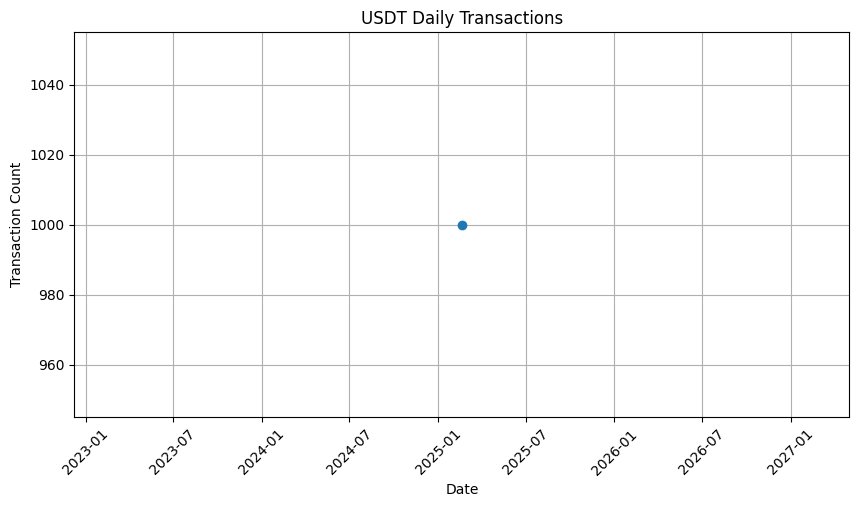

In [26]:
import matplotlib.pyplot as plt

# 日ごとの取引数を集計
df['date'] = df['timeStamp'].dt.date
# 1時間ごとの取引数を集計
# df['date'] = df['timeStamp'].dt.hour
# 1分ごとの取引数を集計
# df['date'] = df['timeStamp'].dt.minute
daily_transactions = df.groupby('date').size()

# 可視化
plt.figure(figsize=(10,5))
plt.plot(daily_transactions.index, daily_transactions.values, marker='o', linestyle='-')
plt.xlabel("Date")
plt.ylabel("Transaction Count")
plt.title("USDT Daily Transactions")
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [10]:
import streamlit as st

st.title("Ethereum トークン取引分析")

# 最新のデータ取得
st.write("### 最新のUSDT取引データ")
st.dataframe(df.head(10))

# 取引量の多いアドレス
st.write("### 取引量の多いアドレス")
st.dataframe(top_addresses.head(10))

# 日ごとの取引数のグラフ
st.write("### USDTの1日ごとの取引数")
st.line_chart(daily_transactions)

st.write("データソース: Etherscan API")

2025-02-19 21:33:12.989 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-19 21:33:13.257 
  command:

    streamlit run C:\Users\fuben\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-02-19 21:33:13.257 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-19 21:33:13.257 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-19 21:33:13.258 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-19 21:33:13.258 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-19 21:33:13.258 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-19 21:33:13.275 Thre